## vanilla-DNN

Author: Justin Tan

Vanilla neural network. Do anything from MNIST to signal classification.

Update 20/03: Added batch normalization, TensorBoard visualization

Update 19/06: Added cosine annealing, exponential moving average

Update 22/09: Moved input pipeline to tfrecords

In [1]:
import tensorflow as tf
import numpy as np
import glob, time, os
import selu
from diagnostics import *

class config(object):
    # Set network parameters
    mode = 'pi0veto'
    channel = 'Bu2Xsy'
    nFeatures = 44
    keep_prob = 0.72
    num_epochs = 2
    batch_size = 512
    n_layers = 5
    hidden_layer_nodes = [1024, 1024, 512, 512, 256]
    ema_decay = 0.999
    learning_rate = 1e-4
    cycles = 8 # Number of annealing cycles
    n_classes = 2
    builder = 'selu'

class directories(object):
    train ='/home/jtan/gpu/jtan/spark/spark2tf/examples/example_train.tfrecords' #'/var/local/tmp/tfrecords/example_train.tfrecords'
    test = '/home/jtan/gpu/jtan/spark/spark2tf/examples/example_test.tfrecords'#'/var/local/tmp/tfrecords/example_test.tfrecords'
    tensorboard = 'tensorboard'
    checkpoints = 'checkpoints'
    
architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)
nTrainExamples=5520000#sum(1 for fn in glob.glob(directories.train+'/*') for record in tf.python_io.tf_record_iterator(fn))
get_available_gpus()

Available GPUs:
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']


In [2]:
def dataset_train(dataDirectory, batchSize, numEpochs, nFeatures, training=True):
    filenames = glob.glob('{}/part*'.format(dataDirectory))
    dataset = tf.contrib.data.TFRecordDataset(filenames)

    # Extract data from `tf.Example` protocol buffer
    def parser(record, batchSize=128):
        keys_to_features = {
            "features": tf.FixedLenFeature([nFeatures], tf.float32),
            "labels": tf.FixedLenFeature((), tf.float32,
            default_value=tf.zeros([], dtype=tf.float32)),
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        label = tf.cast(parsed['labels'], tf.int32)

        return parsed['features'], label

    # Transform into feature, label tensor pair
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dense_builder(x, shape, name, keep_prob, training=True, actv=tf.nn.relu):
    init=tf.contrib.layers.xavier_initializer()
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': True}

    with tf.variable_scope(name, initializer=init) as scope:
        layer = tf.layers.dense(x, units=shape[1], activation=actv)
        bn = tf.layers.batch_normalization(layer, **kwargs)
        layer_out = tf.layers.dropout(bn, keep_prob, training=training)

    return layer_out

def selu_builder(x, shape, name, keep_prob, training=True):
    init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope(name) as scope:
        W = tf.get_variable("weights", shape = shape, initializer=init)
        b = tf.get_variable("biases", shape = [shape[1]], initializer=tf.random_normal_initializer(stddev=0.1))
        actv = selu.selu(tf.add(tf.matmul(x, W), b))
        layer_output = selu.dropout_selu(actv, rate=1-keep_prob, training=training)

    return layer_output

def dense_model(x, n_layers, hidden_layer_nodes, keep_prob, builder=selu_builder, reuse=False, training=True):
    # Extensible dense model
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')
    init = SELU_initializer if builder==selu_builder else tf.contrib.layers.xavier_initializer()
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]

    with tf.variable_scope('dense_model', reuse=reuse):
        hidden_0 = builder(x, shape=[config.nFeatures, hidden_layer_nodes[0]], name='hidden0',
                                keep_prob = keep_prob, training=training)
        layers.append(hidden_0)
        for n in range(0,n_layers-1):
            hidden_n = builder(layers[-1], shape=[hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name='hidden{}'.format(n+1),
                                keep_prob=keep_prob, training=training)
            layers.append(hidden_n)

        readout = tf.layers.dense(hidden_n, units=config.n_classes, kernel_initializer=init)

    return readout

def dense_SELU(x, n_layers, hidden_layer_nodes, keep_prob, reuse=False,
    training=True, actv=selu.selu):
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope('seluNet', reuse=reuse):
        l0 = tf.layers.dense(x, units=hidden_layer_nodes[0], activation=actv,
        kernel_initializer=SELU_initializer)
        d0 = selu.dropout_selu(l0, rate=1-keep_prob, training=training)

        l1 = tf.layers.dense(d0, units=hidden_layer_nodes[1], activation=actv,
        kernel_initializer=SELU_initializer)
        d1 = selu.dropout_selu(l1, rate=1-keep_prob, training=training)

        l2 = tf.layers.dense(d1, units=hidden_layer_nodes[2], activation=actv,
        kernel_initializer=SELU_initializer)
        d2 = selu.dropout_selu(l2, rate=1-keep_prob, training=training)

        l3 = tf.layers.dense(d2, units=hidden_layer_nodes[3], activation=actv,
        kernel_initializer=SELU_initializer)
        d3 = selu.dropout_selu(l3, rate=1-keep_prob, training=training)

        l4 = tf.layers.dense(d3, units=hidden_layer_nodes[4], activation=actv,
        kernel_initializer=SELU_initializer)
        d4 = selu.dropout_selu(l4, rate=1-keep_prob, training=training)

        # Readout layer
        readout = tf.layers.dense(d4, units=config.n_classes,
        kernel_initializer=SELU_initializer)

    return readout

def cosine_anneal(initial_lr, t, T, M):
    from math import ceil
    beta = initial_lr/2 * (np.cos(np.pi* (t % ceil(T/M))/ceil(T/M)) + 1)
    return beta

In [3]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training=True, cyclical=False):
        
        self.global_step = tf.Variable(0, trainable=False)
        self.handle = tf.placeholder(tf.string, shape=[])
        self.training_phase = tf.placeholder(tf.bool)
        self.beta = tf.placeholder(tf.float32) if cyclical else config.learning_rate
#         self.beta = tf.train.exponential_decay(config.learning_rate, self.global_step, 
#                                                decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)
   
        # Feedable iterator defined by handle placeholder and structure.
        trainDataset = dataset_train(directories.train, batchSize=config.batch_size, numEpochs=config.num_epochs, nFeatures=config.nFeatures)
        testDataset = dataset_train(directories.test, batchSize=config.batch_size, numEpochs=config.num_epochs, nFeatures=config.nFeatures)
        self.iterator = tf.contrib.data.Iterator.from_string_handle(self.handle, trainDataset.output_types, 
                                                               trainDataset.output_shapes)

        
        self.train_iterator = trainDataset.make_one_shot_iterator()
        self.test_iterator = testDataset.make_one_shot_iterator()

        self.example, self.label = self.iterator.get_next()
        # self.readout = dense_SELU(self.example, config.n_layers, [1024, 1024, 512, 512, 256], config.keep_prob, training=self.training_phase)
        self.readout = dense_model(self.example, config.n_layers, config.hidden_layer_nodes, config.keep_prob, training=self.training_phase)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.readout, labels = self.label))

        with tf.control_dependencies(update_ops):
            # Ensures that we execute the update_ops before performing the train_step
            self.opt_op = tf.train.AdamOptimizer(self.beta).minimize(self.cross_entropy, name = 'optimizer',
                                                                     global_step = self.global_step)


        self.ema = tf.train.ExponentialMovingAverage(decay = config.ema_decay, num_updates = self.global_step)
        maintain_averages_op = self.ema.apply(tf.trainable_variables())
        
        with tf.control_dependencies([self.opt_op]):
            self.train_op = tf.group(maintain_averages_op)

        # Evaluation metrics
        self.p = tf.nn.softmax(self.readout)
        correct_prediction = tf.equal(tf.cast(tf.argmax(self.readout, 1), tf.int32), self.label)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        _, self.auc_op = tf.metrics.auc(predictions = tf.argmax(self.readout,1), labels = self.label, num_thresholds = 1024)
        tf.summary.scalar('accuracy', self.accuracy)
        tf.summary.scalar('auc', self.auc_op)
        tf.summary.scalar('learning_rate', self.beta)
        tf.summary.scalar('cross_entropy', self.cross_entropy)
        
        self.merge_op = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'train_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'test_{}'.format(time.strftime('%d-%m_%I:%M'))))

    def predict(self, ckpt):
        pin_cpu = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, device_count = {'GPU':0})
        start_time = time.time()
        
        # Restore the moving average version of the learned variables for eval.
        variables_to_restore = self.ema.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        valDataset = dataset_train(directories.test, batchSize=262144, numEpochs=config.num_epochs, 
                                    nFeatures=config.nFeatures, training=False)

        val_iterator = valDataset.make_one_shot_iterator()
        concatLabels = tf.cast(self.label, tf.int32)
        concatPreds = tf.cast(tf.argmax(self.readout,1), tf.int32)
        concatOutput = self.p[:,1]

        with tf.Session(config=pin_cpu) as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())
            assert (ckpt.model_checkpoint_path), 'Missing checkpoint file!'    
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            val_handle = sess.run(val_iterator.string_handle())
            labels, preds, outputs = [], [], []
            while True:
                try:
                    l, p, o = sess.run([concatLabels, concatPreds, concatOutput], 
                                       feed_dict = {vDNN.training_phase: False, vDNN.handle: val_handle})
                    labels.append(l), preds.append(p), outputs.append(o)
                except tf.errors.OutOfRangeError:
                    labels, preds, outputs = np.concatenate(labels), np.concatenate(preds), np.concatenate(outputs)
                    break
            acc = np.mean(np.equal(labels,preds))
            print("Validation accuracy: {:.3f}".format(acc))
            
            plot_ROC_curve(network_output=outputs, y_true=labels, identifier=config.mode+config.channel,
                           meta=architecture + ' | Test accuracy: {:.3f}'.format(acc))
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return labels, preds, outputs

In [4]:
def train(config, restore = False):
    # Executes training operations
    print('Architecture: {}'.format(architecture))
    vDNN = vanillaDNN(config, training=True)
    start_time = time.time()
    global_step, n_checkpoints, v_auc_best = 0, 0, 0.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        train_handle = sess.run(vDNN.train_iterator.string_handle())
        test_handle = sess.run(vDNN.test_iterator.string_handle())
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
        
        while True:
            try:
                # Run X steps on training dataset
                for _ in range(4096):
                    sess.run(vDNN.train_op, feed_dict = {vDNN.training_phase: True, vDNN.handle: train_handle})
                    global_step+=1

                # Single pass over validation dataset
                for _ in range(1):
                    epoch, v_auc_best = run_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, 
                                                        global_step, nTrainExamples, start_time, v_auc_best, n_checkpoints)
                    
            except tf.errors.OutOfRangeError:
                break

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)), 
                               global_step=epoch)
    
    print("Training Complete. Model saved to file: {} Time elapsed: {:.3f} s".format(save_path, time.time()-start_time))

In [6]:
train(config)

Architecture: Bu2Xsy - pi0veto | Layers: 5 | Dropout: 0.72 | Base LR: 0.0001 | Epochs: 2
Epoch 0, Step 2097152 | Training Acc: 0.896 | Test Acc: 0.734 | Test Loss: 1.384 | Test AUC: 0.832 | Rate: 839 examples/s (121.75 s) [*]
Epoch 0, Step 4194304 | Training Acc: 0.832 | Test Acc: 0.744 | Test Loss: 1.275 | Test AUC: 0.771 | Rate: 6494 examples/s (241.07 s) 
Epoch 1, Step 771456 | Training Acc: 0.811 | Test Acc: 0.799 | Test Loss: 0.869 | Test AUC: 0.777 | Rate: 6476 examples/s (361.55 s) 
Epoch 1, Step 2868608 | Training Acc: 0.807 | Test Acc: 0.773 | Test Loss: 1.078 | Test AUC: 0.797 | Rate: 6213 examples/s (482.85 s) 
Epoch 1, Step 4965760 | Training Acc: 0.953 | Test Acc: 0.791 | Test Loss: 0.811 | Test AUC: 0.807 | Rate: 6415 examples/s (605.07 s) 
Training Complete. Model saved to file: checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-1 Time elapsed: 606.224 s


#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

INFO:tensorflow:Restoring parameters from checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-1
checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-1 restored.
Validation accuracy: 0.848
AUC: 0.8942641055827576


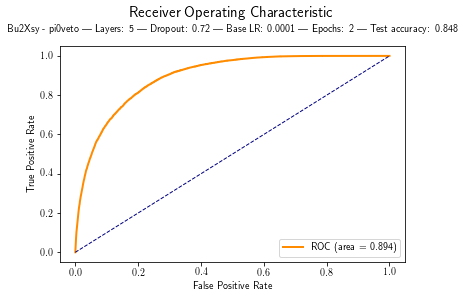

Plotting signal efficiency versus background rejection


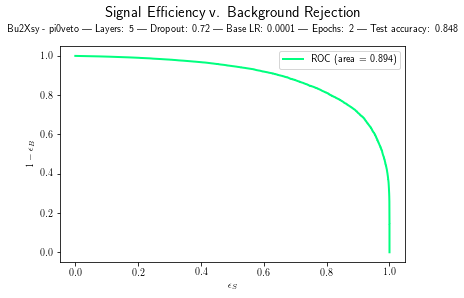

Inference complete. Duration: 26.0885 s


In [5]:
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
labels, preds, output = vDNN.predict(ckpt)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
output.tolist()

[0.9907813668251038,
 0.05039473995566368,
 0.884621262550354,
 0.9996405839920044,
 0.00015342087135650218,
 0.6280800104141235,
 0.0582210011780262,
 0.9877579212188721,
 0.9872825145721436,
 0.9987074136734009,
 0.16737699508666992,
 0.7736568450927734,
 5.1007084725118e-30,
 0.5163956880569458,
 3.3337519349902964e-14,
 0.7787963151931763,
 0.11351200938224792,
 0.8796751499176025,
 0.9239558577537537,
 0.9999392032623291,
 0.8913349509239197,
 0.99637371301651,
 0.990965723991394,
 4.648340450330579e-07,
 0.9956802129745483,
 0.028188219293951988,
 0.9954485297203064,
 0.9992848038673401,
 0.037943340837955475,
 0.7568750381469727,
 0.9053255319595337,
 0.9674948453903198,
 0.7167554497718811,
 5.4415402089172525e-21,
 0.7716109156608582,
 0.002667702967301011,
 0.5553229451179504,
 7.811603808249856e-08,
 0.5511792898178101,
 1.7536036010312653e-29,
 0.0005530606140382588,
 0.9588214159011841,
 0.9998102784156799,
 0.012071918696165085,
 0.8917171359062195,
 0.9365729689598083,
 

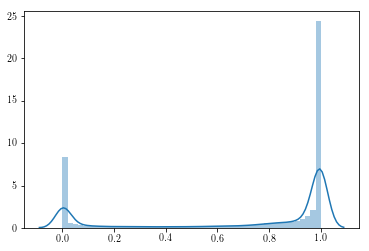

In [12]:
sns.distplot(output)
plt.show()

Building SELU architecture
INFO:tensorflow:Restoring parameters from checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-0
checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-0 restored.
Validation accuracy: 0.857
AUC: 0.8904646780489629


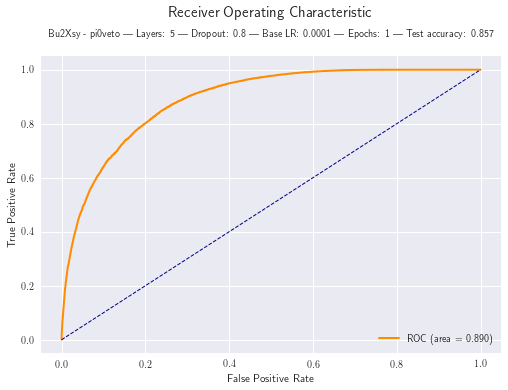

Plotting signal efficiency versus background rejection


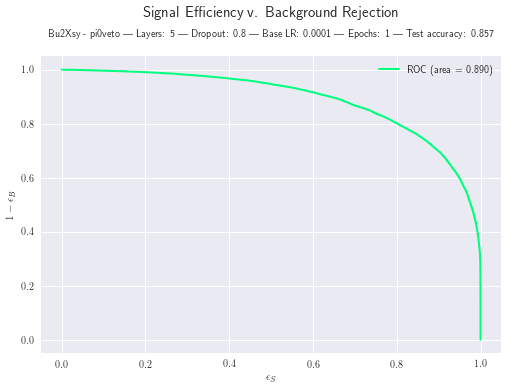

Inference complete. Duration: 42.6341 s


In [6]:
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
labels, preds, output = vDNN.predict(ckpt)